In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_relative
%store -r Y_motion_relative
print(X_motion_relative.shape)
print(Y_motion_relative.shape)

(27032, 27)
(27032, 8)


# Multivariate Linear Regression (Foot prediction)

The input will use initially only:

- **HighCmd: fwd, side, rot speeds**
- **HighState: fwd, side, rot speeds, footPosition2Body (FR)**

and as output we seek to predict the following:

- **footPosition2Body (FR)**

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where FL foot is swinging
idxs = np.where(X_motion_relative[:, 24] == 0)[0]
X_motion_relative_FR_RL = X_motion_relative[idxs]
Y_motion_relative_FR_RL = Y_motion_relative[idxs]

## Predict FL foot -> x

In [8]:
X_motion_relative_FR_RL.shape

(13320, 27)

In [9]:
X_motion_relative_FR_RL[0, :]

array([ 1.00000000e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  7.67128601e-27,  1.56430903e-26,
        7.73122404e-03,  9.99970114e-01,  2.02702748e-04,  1.18196215e-04,
        1.73000000e-01,  1.36000000e-01, -3.40000000e-01,  2.06000000e-01,
       -1.35000000e-01, -3.39000000e-01, -2.68000000e-01,  1.36000000e-01,
       -3.40000000e-01, -2.92000000e-01, -1.36000000e-01, -3.40000000e-01,
        0.00000000e+00,  1.00000000e+00,  1.63241605e+09])

In [10]:
Y_motion_relative_FR_RL[0, :]

array([ 0.029, -0.004, -0.027, -0.002, -0.025,  0.001,  0.02 , -0.001])

### Linear Regression

In [11]:
# Input
#X = np.hstack((X_motion_relative_FR_RL[:, :2], np.array([X_motion_relative_FR_RL[:, 5]]).T,
#               X_motion_relative_FR_RL[:, 6:8], np.array([X_motion_relative_FR_RL[:, 11]]).T,
#               np.array([X_motion_relative_FR_RL[:, 12]]).T, np.array([X_motion_relative_FR_RL[:, 15]]).T))
#X = np.hstack((X_motion_relative_FR_RL[:, :2], np.array([X_motion_relative_FR_RL[:, 5]]).T,
#               np.array([X_motion_relative_FR_RL[:, 12]]).T, np.array([X_motion_relative_FR_RL[:, 15]]).T))
X = np.hstack((X_motion_relative_FR_RL[:, :2],
               np.array([X_motion_relative_FR_RL[:, 5]]).T,
               X_motion_relative_FR_RL[:, 12:14],
               X_motion_relative_FR_RL[:, 15:17],
               X_motion_relative_FR_RL[:, 18:20],
               X_motion_relative_FR_RL[:, 21:23]))

# Target
Y = np.array([Y_motion_relative_FR_RL[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fr_relative_support_x = LinearRegression()

# Fit the model
model_fr_relative_support_x.fit(X_train, Y_train)

# Predict
predictions = model_fr_relative_support_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9705442770854105
RMSE:  0.008374239664338532
The lowest error is:  1.3105057610866833e-06
The highest error is:  0.09283322072397153
The avg. error is:  0.0038649393629247098


In [12]:
model_fr_relative_support_x.intercept_

array([-0.00941408])

Text(0, 0.5, 'Predictions')

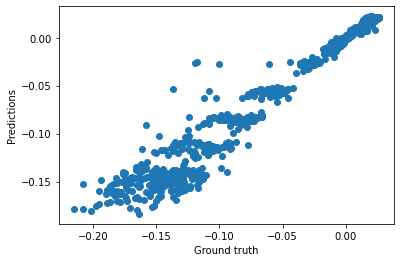

In [13]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [13]:
%store model_fr_relative_support_x

Stored 'model_fr_relative_support_x' (LinearRegression)


In [14]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [15]:
# Save model
joblib.dump(model_fr_relative_support_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fr_relative_support_x.sav")

['/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fr_relative_support_x.sav']

### Predict FL foot -> y

In [14]:
# Input
#X = np.hstack((X_motion_relative_FR_RL[:, :2], np.array([X_motion_relative_FR_RL[:, 5]]).T,
#               X_motion_relative_FR_RL[:, 6:8], np.array([X_motion_relative_FR_RL[:, 11]]).T,
#               np.array([X_motion_relative_FR_RL[:, 12]]).T, np.array([X_motion_relative_FR_RL[:, 15]]).T))
#X = np.hstack((X_motion_relative_FR_RL[:, :2], np.array([X_motion_relative_FR_RL[:, 5]]).T,
#               np.array([X_motion_relative_FR_RL[:, 12]]).T, np.array([X_motion_relative_FR_RL[:, 15]]).T))
X = np.hstack((X_motion_relative_FR_RL[:, :2],
               np.array([X_motion_relative_FR_RL[:, 5]]).T,
               X_motion_relative_FR_RL[:, 12:14],
               X_motion_relative_FR_RL[:, 15:17],
               X_motion_relative_FR_RL[:, 18:20],
               X_motion_relative_FR_RL[:, 21:23]))

# Target
Y = np.array([Y_motion_relative_FR_RL[:, 3]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, test_size=0.2, shuffle=True, random_state=100)

# Create the model
model_fr_relative_support_y = LinearRegression()

# Fit the model
model_fr_relative_support_y.fit(X_train, Y_train)

# Predict
predictions = model_fr_relative_support_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9833969490555458
RMSE:  0.005940881935195772
The lowest error is:  1.1955049329798184e-06
The highest error is:  0.03295340588543254
The avg. error is:  0.004249537248917952


In [15]:
model_fr_relative_support_y.intercept_

array([-0.08364543])

Text(0, 0.5, 'Predictions')

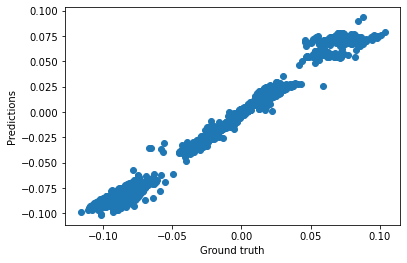

In [16]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [18]:
%store model_fr_relative_support_y

Stored 'model_fr_relative_support_y' (LinearRegression)


In [19]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [20]:
# Save model
joblib.dump(model_fr_relative_support_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fr_relative_support_y.sav")

['/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fr_relative_support_y.sav']